In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# Load dataset
data = pd.read_excel('Dataset.xlsx', engine='openpyxl')
data.head()

,Team,Match Up,Game Date,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
0,GSW,GSW vs. PHX,10/24/2023,L,240,104,36,101,35.6,10,...,78.6,18,31,49,19,11,6,11,23,-4
1,PHX,PHX @ GSW,10/24/2023,W,240,108,42,95,44.2,11,...,76.5,17,43,60,23,5,7,19,22,4
2,LAL,LAL @ DEN,10/24/2023,L,240,107,41,90,45.6,10,...,75,13,31,44,23,5,4,12,18,-12
3,DEN,DEN vs. LAL,10/24/2023,W,240,119,48,91,52.7,14,...,75,9,33,42,29,9,6,12,15,12
4,MEM,MEM vs. NOP,10/25/2023,L,240,104,38,91,41.8,12,...,80,8,29,37,23,8,7,13,19,-7


Manipulate Data:

In [3]:
# Convert game date to datetime
data['Game Date'] = pd.to_datetime(data['Game Date'], format='%m/%d/%Y')

# Extract home and guest teams
data['Home Team'] = data['Match Up'].apply(lambda x: x.split(' vs. ')[0] if 'vs.' in x else x.split(' @ ')[1])
data['Guest Team'] = data['Match Up'].apply(lambda x: x.split(' vs. ')[1] if 'vs.' in x else x.split(' @ ')[0])

# Add the correct Label column: 1 if home team won, 0 otherwise
data['Label'] = data.apply(
    lambda row: 1 if ((row['Team'] == row['Home Team']) and (row['W/L'] == 'W')) 
                    or ((row['Team'] == row['Guest Team']) and (row['W/L'] == 'L'))
                else 0,
    axis=1
)
data.head()

,Team,Match Up,Game Date,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,REB,AST,STL,BLK,TOV,PF,+/-,Home Team,Guest Team,Label
0,GSW,GSW vs. PHX,2023-10-24,L,240,104,36,101,35.6,10,...,49,19,11,6,11,23,-4,GSW,PHX,0
1,PHX,PHX @ GSW,2023-10-24,W,240,108,42,95,44.2,11,...,60,23,5,7,19,22,4,GSW,PHX,0
2,LAL,LAL @ DEN,2023-10-24,L,240,107,41,90,45.6,10,...,44,23,5,4,12,18,-12,DEN,LAL,1
3,DEN,DEN vs. LAL,2023-10-24,W,240,119,48,91,52.7,14,...,42,29,9,6,12,15,12,DEN,LAL,1
4,MEM,MEM vs. NOP,2023-10-25,L,240,104,38,91,41.8,12,...,37,23,8,7,13,19,-7,MEM,NOP,0


Baseline dataset - without any new features:

In [4]:
# Baseline dataset
# Initialize the new dataset
new_dataset = []

# Iterate over each match-up
for _, row in data.iterrows():
    game_date = row['Game Date']
    home_team = row['Home Team']
    guest_team = row['Guest Team']
    
    # Filter games before the current game date for both teams
    home_team_games = data[(data['Team'] == home_team) & (data['Game Date'] < game_date)]
    guest_team_games = data[(data['Team'] == guest_team) & (data['Game Date'] < game_date)]
    
    # Calculate W/L rates (win rates) for both teams
    home_team_wins = (home_team_games['W/L'] == 'W').sum()
    home_team_total = len(home_team_games)
    guest_team_wins = (guest_team_games['W/L'] == 'W').sum()
    guest_team_total = len(guest_team_games)
    
    home_win_rate = home_team_wins / home_team_total if home_team_total > 0 else 0
    guest_win_rate = guest_team_wins / guest_team_total if guest_team_total > 0 else 0
    
    # Calculate W/L difference
    wl_difference = home_win_rate - guest_win_rate
    
    # Prepare the new row
    new_row = {
        'Game Date': game_date,
        'Home Team': home_team,
        'Guest Team': guest_team,
        'Label': int(row['Label']),  # Ensure Label is directly copied and kept as integer
        'W/L Difference': wl_difference
    }
    
    # Add statistics differences (like in the original approach)
    home_team_stats = home_team_games.iloc[:, 4:].mean(numeric_only=True)
    guest_team_stats = guest_team_games.iloc[:, 4:].mean(numeric_only=True)
    
    if not home_team_stats.empty and not guest_team_stats.empty:
        stats_diff = home_team_stats - guest_team_stats
        # Update new_row but ensure no conflict with 'Label'
        new_row.update({k: v for k, v in stats_diff.to_dict().items() if k != 'Label'})
    
    new_dataset.append(new_row)

# Convert to DataFrame
new_dataset_df = pd.DataFrame(new_dataset)

# Save to file for inspection
output_file = 'output_dataset/Dataset_without_New_Features.xlsx'
new_dataset_df.to_excel(output_file, index=False)

output_file

'output_dataset/Dataset_without_New_Features.xlsx'

In [5]:
# Remove rows with NaN values and drop duplicate rows
dataset_df = new_dataset_df.dropna().drop_duplicates()

# Save to file for inspection
output_file = 'output_dataset/cleaned_final_dataset.xlsx'
dataset_df.to_excel(output_file, index=False)
output_file
dataset_df.head()

,Game Date,Home Team,Guest Team,Label,W/L Difference,MIN,PTS,FGM,FGA,FG%,...,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
29,2023-10-26,LAL,PHX,1,-1.0,0.0,-1.0,-1.0,-5.0,1.4,...,3.0,-4.0,-12.0,-16.0,0.0,0.0,-3.0,-7.0,-4.0,-16.0
32,2023-10-27,SAS,HOU,1,0.0,0.0,33.0,14.0,10.0,11.2,...,6.0,2.0,12.0,14.0,14.0,2.0,2.0,0.0,-1.0,23.0
33,2023-10-27,BOS,MIA,1,0.0,0.0,5.0,0.0,-15.0,7.9,...,0.0,-9.0,7.0,-2.0,-4.0,-5.0,8.0,6.0,4.0,3.0
34,2023-10-27,UTA,LAC,1,-1.0,0.0,-9.0,-6.0,1.0,-7.1,...,15.0,2.0,7.0,9.0,-14.0,-5.0,-5.0,-4.0,0.0,-28.0
35,2023-10-27,SAC,GSW,0,1.0,0.0,26.0,11.0,1.0,10.5,...,-8.0,-3.0,-1.0,-4.0,10.0,-5.0,2.0,1.0,2.0,20.0


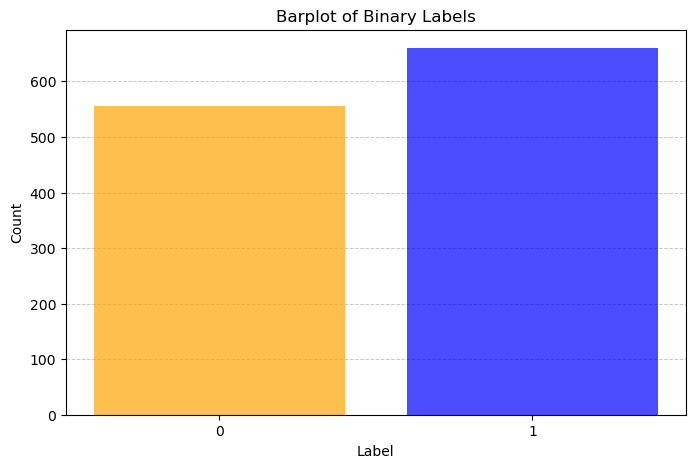

In [11]:
X = dataset_df.drop(columns=['Label', 'Game Date', 'Home Team', 'Guest Team']) # Features: all columns except 'Label'
y = dataset_df['Label']  # Labels: the 'Label' column
import matplotlib.pyplot as plt
import pandas as pd

# Extract `y` from your dataset
y = dataset_df['Label']  # Assuming 'Label' contains 0s and 1s

# Calculate the counts of each class
value_counts = y.value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(value_counts.index, value_counts.values, color=['blue', 'orange'], alpha=0.7, zorder=2)
plt.title("Barplot of Binary Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(value_counts.index)  # Ensure x-axis shows class labels (e.g., 0 and 1)

# Add grid lines for clarity
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7, zorder=1)

plt.show()

Using data standardization and L1 regularization to complete Feature Selection.

In [10]:
# Step 1: Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)  # Standardize X to have zero mean and unit variance

# Step 2: Fit Logistic Regression with L1 regularization for binary model
lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)  # L1 penalty for feature selection
lasso_log_reg.fit(X_standardized, y)

# Step 3: Identify selected features
selected_features = X.columns[(lasso_log_reg.coef_ != 0).flatten()]  # Keep only features with non-zero coefficients
X_selected = X[selected_features]  # Subset original X with selected features

print(f"Selected features: {list(selected_features)}")
print(X_selected.head())

Selected features: ['W/L Difference', 'MIN', 'PTS', 'FGM', 'FG%', '3PA', 'FTM', 'FTA', 'OREB', 'REB', 'AST', 'STL', 'TOV', 'PF', '+/-']
    W/L Difference  MIN   PTS   FGM   FG%   3PA   FTM   FTA  OREB   REB   AST  \
29            -1.0  0.0  -1.0  -1.0   1.4  -4.0   2.0   3.0  -4.0 -16.0   0.0   
32             0.0  0.0  33.0  14.0  11.2   1.0   6.0   6.0   2.0  14.0  14.0   
33             0.0  0.0   5.0   0.0   7.9  17.0   1.0   0.0  -9.0  -2.0  -4.0   
34            -1.0  0.0  -9.0  -6.0  -7.1  -6.0  10.0  15.0   2.0   9.0 -14.0   
35             1.0  0.0  26.0  11.0  10.5   8.0  -5.0  -8.0  -3.0  -4.0  10.0   

    STL  TOV   PF   +/-  
29  0.0 -7.0 -4.0 -16.0  
32  2.0  0.0 -1.0  23.0  
33 -5.0  6.0  4.0   3.0  
34 -5.0 -4.0  0.0 -28.0  
35 -5.0  1.0  2.0  20.0  


Training & Testing using 5-fold cv (including Random Forest, Logistic Regression, Decision Tree, AdaBoost, and QDA):

The accuracy of logistic regression is the highest which is about 0.64 for baseline dataset.

In [16]:
# Ensure data is shuffled before splitting
X_shuffled, y_shuffled = shuffle(X_selected, y, random_state=0)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    #'QDA': QuadraticDiscriminantAnalysis()
}

# Initialize K-Fold with shuffle
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Store accuracies for each model
model_accuracies = {model_name: [] for model_name in models}

for train_index, test_index in kf.split(X_shuffled):
    # Split the data into training and testing sets
    X_train, X_test = X_shuffled.iloc[train_index], X_shuffled.iloc[test_index]
    y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
    
    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        model_accuracies[model_name].append(accuracy)

# Print results
for model_name, accuracies in model_accuracies.items():
    print(f"{model_name} Accuracy for each fold: {accuracies}")
    print(f"{model_name} Mean accuracy: {sum(accuracies) / len(accuracies):.2f}")

Random Forest Accuracy for each fold: [0.6378600823045267, 0.5843621399176955, 0.6131687242798354, 0.6625514403292181, 0.5637860082304527]
Random Forest Mean accuracy: 0.61
Logistic Regression Accuracy for each fold: [0.6378600823045267, 0.654320987654321, 0.6502057613168725, 0.7078189300411523, 0.5679012345679012]
Logistic Regression Mean accuracy: 0.64
Decision Tree Accuracy for each fold: [0.5761316872427984, 0.5432098765432098, 0.5843621399176955, 0.5679012345679012, 0.6090534979423868]
Decision Tree Mean accuracy: 0.58
AdaBoost Accuracy for each fold: [0.6213991769547325, 0.6378600823045267, 0.6296296296296297, 0.6625514403292181, 0.5637860082304527]
AdaBoost Mean accuracy: 0.62


In [18]:
# Step 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=8)

# Maybe removes some data without enough previous matches
#X_train = X_train[300:]
#y_train = y_train[300:]

# Step 2: Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer
    Dropout(0.3),  # Dropout for regularization
    Dense(32, activation='relu'),  # Second hidden layer
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Step 4: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 6: Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)

print(f"Neural Network Test Accuracy: {accuracy:.2f}")


Epoch 1/20
27/27 [==============================] - 0s 6ms/step - loss: 0.6663 - accuracy: 0.5988 - val_loss: 0.6396 - val_accuracy: 0.6137
Epoch 2/20
27/27 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.6506 - val_loss: 0.6257 - val_accuracy: 0.6301
Epoch 3/20
27/27 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6718 - val_loss: 0.6231 - val_accuracy: 0.6329
Epoch 4/20
27/27 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6576 - val_loss: 0.6241 - val_accuracy: 0.6438
Epoch 5/20
27/27 [==============================] - 0s 5ms/step - loss: 0.6211 - accuracy: 0.6635 - val_loss: 0.6243 - val_accuracy: 0.6329
Epoch 6/20
27/27 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6694 - val_loss: 0.6252 - val_accuracy: 0.6356
Epoch 7/20
27/27 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.6671 - val_loss: 0.6222 - val_accuracy: 0.6411
Epoch 8/20
27/27 [==